In [1]:
import itertools
import math
from time import perf_counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageTransform
from vtkmodules.numpy_interface.algorithms import condition

In [2]:
def transformation(
    translation: tuple[int, int] = (0, 0),
    scaling: tuple[float, float] = (1.0, 1.0),
    rotation: float = 0.0,
    shearing: tuple[float, float] = (0.0, 0.0),
    transformation_origin: tuple[int, int] = (0, 0),
) -> np.ndarray:
    matrix = np.eye(3, 3)

    # Change origin
    matrix = (
        np.array(
            [
                [1, 0, -transformation_origin[0]],
                [0, 1, -transformation_origin[1]],
                [0, 0, 1],
            ]
        )
        @ matrix
    )

    # Rotate
    matrix = (
        np.array(
            [
                [math.cos(rotation), -math.sin(rotation), 0],
                [math.sin(rotation), math.cos(rotation), 0],
                [0, 0, 1],
            ]
        )
        @ matrix
    )

    # Scale
    matrix = (
        np.array(
            [
                [scaling[0], 0, 0],
                [0, scaling[1], 0],
                [0, 0, 1],
            ]
        )
        @ matrix
    )

    # Change origin back
    matrix = (
        np.array(
            [
                [1, 0, transformation_origin[0]],
                [0, 1, transformation_origin[1]],
                [0, 0, 1],
            ]
        )
        @ matrix
    )

    # Shear
    matrix = (
        np.array(
            [
                [1, shearing[0], 0],
                [shearing[1], 1, 0],
                [0, 0, 1],
            ]
        )
        @ matrix
    )

    # Translate
    matrix = (
        np.array(
            [
                [1, 0, translation[0]],
                [0, 1, translation[1]],
                [0, 0, 1],
            ]
        )
        @ matrix
    )

    return matrix

In [13]:
shape = (10_000, 4_000)

# image = np.random.randint(0, 2**16 - 1, np.prod(shape), dtype=np.uint16).reshape(shape)
image = np.zeros(shape, dtype=np.uint16)

image[0 : round(image.shape[0] * 0.8), 0] = 255
image[0, 0 : image.shape[1]] = 255
image[0 : round(image.shape[0] * 0.5), image.shape[1] - 1] = 255
image[round(image.shape[0] * 0.5) - 1, 0 : image.shape[1]] = 255
for i in range(round(image.shape[0] * 0.5) - 1, round(image.shape[1] * 0.8)):
    image[i, i] = 255

In [4]:
matrix = transformation(
    rotation=math.pi / 2,
    transformation_origin=(image.shape[0] // 2, image.shape[1] // 2),
)

In [104]:
transformed_image_a = np.zeros_like(image)

start_time = perf_counter()

for i, j in itertools.product(range(image.shape[0]), range(image.shape[1])):
    coordinates = np.array([i, j, 1])
    i_out, j_out, _ = np.round(matrix @ coordinates).astype(int)

    if 0 <= i_out < image.shape[0] and 0 <= j_out < image.shape[1]:
        transformed_image_a[i_out, j_out] = image[i, j]

print(f"Elapsed time: {perf_counter() - start_time:.2f} seconds.")

Elapsed time: 3.35 seconds.


In [15]:
transformed_image_b = np.zeros_like(image)

initial_time = perf_counter()

start_time = perf_counter()
x, y, z = np.meshgrid(
    list(range(image.shape[0])), list(range(image.shape[1])), [1], indexing="ij"
)
print(f"Meshgrid: {perf_counter() - start_time:.2f} seconds.")

start_time = perf_counter()
coordinates = np.vstack([x.ravel(), y.ravel(), z.ravel()])
print(f"Stacking: {perf_counter() - start_time:.2f} seconds.")

start_time = perf_counter()
transformed_coordinates = matrix @ coordinates
print(f"Transforming 1: {perf_counter() - start_time:.2f} seconds.")
start_time = perf_counter()
transformed_coordinates = np.round(transformed_coordinates).astype(int)
print(f"Transforming 2: {perf_counter() - start_time:.2f} seconds.")

start_time = perf_counter()
condition = transformed_coordinates[:2] < np.array(transformed_image_b.shape).reshape(
    2, 1
)
print(f"Condition 1: {perf_counter() - start_time:.2f} seconds.")
start_time = perf_counter()
condition = np.all(condition, axis=0)
print(f"Condition 2: {perf_counter() - start_time:.2f} seconds.")

start_time = perf_counter()
coordinates = coordinates[:2][..., condition]
transformed_coordinates = transformed_coordinates[:2][..., condition]
print(f"Filtering: {perf_counter() - start_time:.2f} seconds.")

i, j = coordinates
i_out, j_out = transformed_coordinates

start_time = perf_counter()
transformed_image_b[i_out, j_out] = image[i, j]
print(f"Insertion: {perf_counter() - start_time:.2f} seconds.")

print(f"Total time: {perf_counter() - initial_time:.2f} seconds.")

Meshgrid: 0.36 seconds.
Stacking: 1.67 seconds.
Transforming 1: 1.59 seconds.
Transforming 2: 1.38 seconds.
Condition 1: 0.07 seconds.
Condition 2: 0.11 seconds.
Filtering: 1.32 seconds.
Insertion: 0.28 seconds.
Total time: 6.79 seconds.


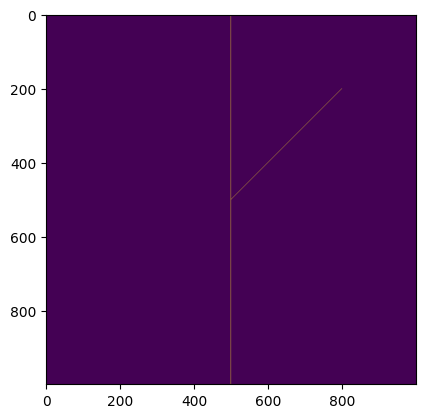

In [106]:
plt.imshow(transformed_image_a)

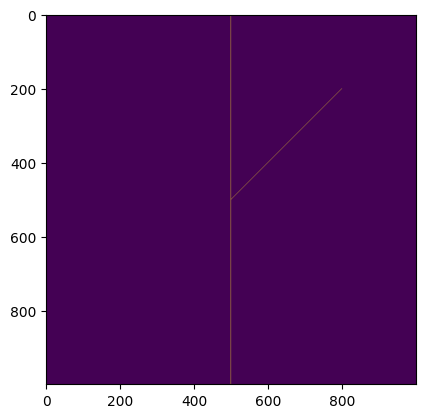

In [107]:
plt.imshow(transformed_image_b)